# Handwritten Digits Generator With a GAN
Generative adversarial networks can also generate high-dimensional samples such as images. In this example, you’re going to use a GAN to generate images of handwritten digits. For that, you’ll train the models using the MNIST dataset of handwritten digits, which is included in the torchvision package.



In [ ]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

You can ensure your code will run on either setup by creating a device object that points either to the CPU or, if one is available, to the GPU:

In [ ]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Preparing the Training Data
The MNIST dataset consists of 28 × 28 pixel grayscale images of handwritten digits from 0 to 9. To use them with PyTorch, you’ll need to perform some conversions. For that, you define transform, a function to be used when loading the data:

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [ ]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

100%|██████████| 9912422/9912422 [00:00<00:00, 213241582.01it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 84063632.08it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 63193452.09it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14520220.10it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

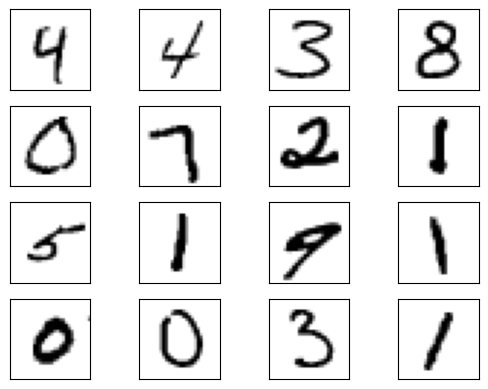

In [ ]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

# Implementing the Discriminator and the Generator


In this case, the discriminator is an MLP neural network that receives a 28 × 28 pixel image and provides the probability of the image belonging to the real training data.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [ ]:
discriminator = Discriminator().to(device=device)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

# Training the Models

In [ ]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5291712284088135
Epoch: 0 Loss G.: 0.5677768588066101
Epoch: 1 Loss D.: 0.01849963515996933
Epoch: 1 Loss G.: 6.919445514678955
Epoch: 2 Loss D.: 0.039831504225730896
Epoch: 2 Loss G.: 4.991153717041016
Epoch: 3 Loss D.: 0.0022818383295089006
Epoch: 3 Loss G.: 6.337048530578613
Epoch: 4 Loss D.: 0.005341513082385063
Epoch: 4 Loss G.: 5.412222862243652
Epoch: 5 Loss D.: 0.07728660106658936
Epoch: 5 Loss G.: 4.549190044403076
Epoch: 6 Loss D.: 0.005790185648947954
Epoch: 6 Loss G.: 10.431031227111816
Epoch: 7 Loss D.: 3.983811845076851e-18
Epoch: 7 Loss G.: 57.21709060668945
Epoch: 8 Loss D.: 1.511283542754427e-08
Epoch: 8 Loss G.: 26.820533752441406
Epoch: 9 Loss D.: 2.0836318981309887e-06
Epoch: 9 Loss G.: 21.067256927490234
Epoch: 10 Loss D.: 6.49019588072619e-11
Epoch: 10 Loss G.: 29.27088737487793
Epoch: 11 Loss D.: 4.925471797099187e-22
Epoch: 11 Loss G.: 62.771968841552734
Epoch: 12 Loss D.: 9.782039812679812e-22
Epoch: 12 Loss G.: 66.65126037597656
Epoch: 13 L

# Checking the Samples Generated by the GAN
To generate handwritten digits, you have to take some random samples from the latent space and feed them to the generator:

In [12]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

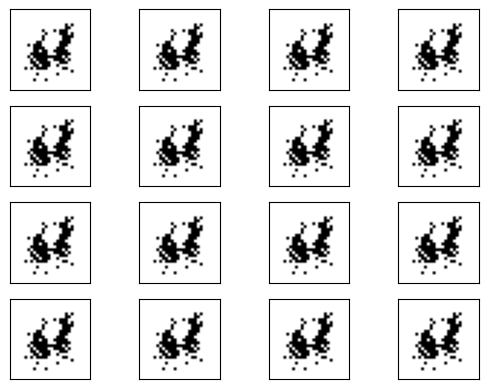

In [13]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

# Conclusion
Congratulations! You’ve learned how to implement your own generative adversarial networks. You first went through a toy example to understand the GAN structure before diving into a practical application that generates images of handwritten digits.

You saw that, despite the complexity of GANs, machine learning frameworks like PyTorch make the implementation more straightforward by offering automatic differentiation and easy GPU setup.

In this tutorial, you learned:

What the difference is between discriminative and generative models
How generative adversarial networks are structured and trained
How to use tools like PyTorch and a GPU to implement and train GAN models